# Assignment Machine Learning
***Assignment BIT07 / Bioinformatics @ home***

**Student name**: Glenn Broeckx  
**Student number**: 202054838

## PART 1: Choosing the dataset
For this assignment, a dataset on breast cancer characteristics, RNA expression and survival was chosen. This dataset is originating from the METABRIC clinical trials published in Nature (2012), wherein an European research group mapped genomic and transcriptomic profiles in breast cancer. (1)

This dataset has a mixture of categorical variables (both ordinal and nominal) and numerical variables. It has the possibility to predict survival in both status as survival duration. Furhtermore, it is possible to predict the type of breast cancer based on gene expression profiling and gene mutational profiling, which was the main goal of the METABRIC clinical trial. 

The METABRIC dataset is freely available on the Kaggle website under the Database Contents License (DbCL) [v1.0] from following url: [https://www.kaggle.com/raghadalharbi/breast-cancer-gene-expression-profiles-metabric](https://www.kaggle.com/raghadalharbi/breast-cancer-gene-expression-profiles-metabric).

In this Jupyter Notebook file, all modules, methods and functions will be imported. Several own created functions will be declared as well.

In [505]:
# Importing modules, functions and methods
###################################################
# Data analysis and scientific calculations
from scipy import stats
import numpy as np
import pandas as pd
import opendatasets as od

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 20,8.27 #size of figures in inch

# Machine learning modules
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, det_curve, balanced_accuracy_score, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

# Own functies
################
def listdiff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif


def ohe_and_bind(original_dataframe, features_to_encode):
    if type(features_to_encode) is not list:
        raise Exception("Features to encode needs to be a list")

    for f_encode in features_to_encode:
        dummies = pd.get_dummies(original_dataframe[[f_encode]])
        original_dataframe = original_dataframe.drop(f_encode, axis=1)
        original_dataframe = pd.concat([original_dataframe, dummies], axis=1)

    return(original_dataframe)



## PART 2: Describing the dataset
The downloaded dataset is imported into a Pandas DataFrame, called `bc`, short for breast cancer. In this Notebook, variables derived from `bc` will further be named with a `bc_` prefix, followed by a short indication of derivation. 

In [449]:
# 2.1: Importing dataset
bc = pd.read_csv('METABRIC_RNA_Mutation.csv', dtype={678:'unicode', 688:'unicode', 690:'unicode', 692:'unicode'})
bc.head()

patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type                       cancer_type_detailed cellularity  chemotherapy pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc er_status  neoplasm_histologic_grade her2_status_measured_by_snp6 her2_status tumor_other_histologic_subtype  hormone_therapy inferred_menopausal_state integrative_cluster primary_tumor_laterality  lymph_nodes_examined_positive  mutation_count  nottingham_prognostic_index oncotree_code  overall_survival_months  overall_survival pr_status  radio_therapy 3-gene_classifier_subtype  tumor_size  tumor_stage death_from_cancer   brca1   brca2   palb2    pten    tp53     atm    cdh1   chek2     nbn     nf1   stk11   bard1    mlh1    msh2    msh6    pms2   epcam  rad51c  rad51d   rad50     rb1    rbl1    rbl2   ccna1   ccnb1    cdk1   ccne1    cdk2  cdc25a   ccnd1    cdk4    cdk6   ccnd2  cdkn2a  cdkn2b     myc  cdkn1a  cdkn1b    e2f1    e2f2    e2f3    e2f4    e2f5    e2f6    e2f7    e2f8  \
0           0             75.65             MASTECTOMY  Breast Cancer           Breast Invasive Ductal Carcinoma         NaN             0                 claudin-low     1.0                   Positve  Positive                        3.0                      NEUTRAL    Negative                     Ductal/NST                1                      Post                4ER+                    Right                           10.0             NaN                        6.044           IDC               140.500000                 1  Negative              1                 ER-/HER2-        22.0          2.0            Living -1.3990 -0.5738 -1.6217  1.4524  0.3504  1.1517  0.0348  0.1266 -0.8361 -0.8578 -0.4294 -1.1201 -0.4844 -0.7483 -1.6660 -0.1250 -0.3721 -0.6508 -0.1278  1.7330 -0.2770 -1.0673  0.0615  0.1034 -1.6635 -2.0649 -1.3388 -0.6208 -1.7309 -0.8059 -1.1037  0.0744  1.4313 -0.5785  1.2180  2.5602  2.3152 -0.2487  0.1601 -1.8799 -1.3629  0.1992 -0.0907 -0.1167 -1.3917 -0.8178   
1           2             43.19      BREAST CONSERVING  Breast Cancer           Breast Invasive Ductal Carcinoma        High             0                        LumA     1.0                   Positve  Positive                        3.0                      NEUTRAL    Negative                     Ductal/NST                1                       Pre                4ER+                    Right                            0.0             2.0                        4.020           IDC                84.633333                 1  Positive              1     ER+/HER2- High Prolif        10.0          1.0            Living -1.3800  0.2777 -1.2154  0.5296 -0.0136 -0.2659  1.3594  0.7961  0.5419 -2.6059  0.5120  0.4390  1.2266  0.7612  0.1821  1.0104  0.5600 -0.4018 -0.2909  0.7440 -1.7488  0.4602  0.7835 -0.2690 -0.2715  0.3895 -0.6273  0.1813 -1.2643  1.1057  0.4108 -0.6040  0.0546  0.2754 -0.0952  0.7248  0.4389  1.8759 -1.8984 -0.3327 -1.4560  1.0011  0.0519 -0.3793 -0.4915 -1.3693   
2           5             48.87             MASTECTOMY  Breast Cancer           Breast Invasive Ductal Carcinoma        High             1                        LumB     1.0                   Positve  Positive                        2.0                      NEUTRAL    Negative                     Ductal/NST                1                       Pre                   3                    Right                            1.0             2.0                        4.030           IDC               163.700000                 0  Positive              0                       NaN        15.0          2.0   Died of Disease  0.0670 -0.8426  0.2114 -0.3326  0.5141 -0.0803  1.1398  0.4187 -0.4030 -1.1305  0.2362 -0.1721 -1.7910  3.0955  0.6608  2.6127  2.5553 -0.0391 -0.4421  1.4528  1.4142  0.3143 -0.0662 -0.5558  0.6967  1.2949 -0.1245 -0.1109 -0.3923 -1.2747 -0.5312  0.2585  0.8958 -0.2270  1.1899 -0.7207  1.4829  3.0696  2.2248 -1.4859 -0.4127 -0.8333  0.2885 -0.3496 -0.3549  0.0908   
3           6      

In [450]:
bc_shape = bc.shape
print(f'Number of rows/observations/patients in the dataframe:\t{bc_shape[0]:5d}')
print(f'Number of columns/features/attributes in the dataframe:\t{bc_shape[1]:5d}')

Number of rows/observations/patients in the dataframe:	 1904
Number of columns/features/attributes in the dataframe:	  693


The `head()` method defaulty shows the first 5 rows of the dataframe. It is followed with the dimensions of the shown dataframe, But because only the head method is used, the number of observations/rows was limited to 5. The `shape` method gives a better overview of the overall dimensions of the dataframe. As presented in the output of previous code cell, these are the dimensions:

- Number of rows/observations/patients in the dataframe: 1904
- Number of columns/features/attributes in the dataframe: 693

In the `read_csv()` method the attribute `dtype` is added to certain columns because of generic DtypeWarning errors that were raised. As these columns contain string values, dtype for these columns are set to `unicode`

### 2.1 Describing the attributes
As previously discussed, 693 attributes are present in this dataset. These are quite a lot to individually discuss them in a table. The high number of attributes is caused by the genomic and transcriptomic mapping, in which each gene has its own attribute. Transcriptomic mapping starts at column with name `brca1`, genomics mapping starts at column with name `pik3ca_mut`. In the next cell, the indices of thise columns are given.

In [451]:
print(f'Starting index of transcriptomics (starting at brca1):\t{bc.columns.get_loc("brca1"):5d}')
print(f'Starting index of genomics (starting at pik3ca_mut):\t{bc.columns.get_loc("pik3ca_mut"):5d}')

Starting index of transcriptomics (starting at brca1):	   31
Starting index of genomics (starting at pik3ca_mut):	  520


In following overview, all attributes concerning transcriptomics (columns with index 31 to 519) and all attributes concerning genomics (columns with index 520 to 692) are lumped together for readability.

The following overview is based on information from the `describe()` method, the Kaggle website and from the METABRIC publication.

In [452]:
# 2.1: Describing the dataset
bc.describe() # range van waarden; vul ook aan met info over kolommen van bron

patient_id  age_at_diagnosis  chemotherapy       cohort  neoplasm_histologic_grade  hormone_therapy  lymph_nodes_examined_positive  mutation_count  nottingham_prognostic_index  overall_survival_months  overall_survival  radio_therapy   tumor_size  tumor_stage         brca1         brca2         palb2          pten          tp53           atm         cdh1         chek2           nbn          nf1         stk11         bard1         mlh1          msh2          msh6          pms2         epcam       rad51c        rad51d         rad50           rb1          rbl1          rbl2         ccna1         ccnb1          cdk1         ccne1          cdk2        cdc25a        ccnd1          cdk4          cdk6         ccnd2        cdkn2a        cdkn2b           myc       cdkn1a       cdkn1b          e2f1          e2f2          e2f3         e2f4          e2f5          e2f6         e2f7         e2f8           src          jak1          jak2         stat1         stat2         stat3  \
count  1904.000000       1904.000000   1904.000000  1904.000000                1832.000000      1904.000000                    1904.000000     1859.000000                  1904.000000              1904.000000       1904.000000    1904.000000  1884.000000  1403.000000  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1904.000000  1.904000e+03  1.904000e+03  1904.000000  1.904000e+03  1.904000e+03  1904.000000  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1904.000000  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1904.000000  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1904.000000  1904.000000  1.904000e+03  1.904000e+03  1.904000e+03  1904.000000  1.904000e+03  1.904000e+03  1904.000000  1904.000000  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03  1.904000e+03   
mean   3921.982143         61.087054      0.207983     2.643908                   2.415939         0.616597                       2.002101        5.697687                     4.033019               125.121324          0.420693       0.597164    26.238726     1.750535 -6.302521e-07 -4.201681e-07  3.676471e-07 -8.928571e-07  6.302521e-07 -2.100840e-07     0.000002  7.463684e-18 -3.676471e-07    -0.000001 -4.726891e-07  5.777311e-07    -0.000001  5.252101e-07 -5.252101e-08 -3.676471e-07  1.492737e-17     0.000002 -3.676471e-07 -8.928571e-07 -9.978992e-07  5.252101e-08  1.050420e-07 -5.777311e-07  3.676471e-07  2.626050e-07 -5.252101e-08  2.100840e-07  3.151261e-07     0.000001 -9.978992e-07  6.302521e-07 -2.100840e-07  6.302521e-07  9.978992e-07 -5.777311e-07     0.000001     0.000002  9.453782e-07 -6.827731e-07 -5.252101e-07    -0.000001  6.302521e-07 -5.252101e-07     0.000001    -0.000001 -3.676471e-07  2.100840e-07  9.453782e-07 -1.575630e-07  5.252101e-07 -1.575630e-07   
std    2358.478332         12.978711      0.405971     1.228615                   0.650612         0.486343                       4.079993        4.058778                     1.144492                76.334148          0.493800       0.490597    15.160976     0.628999  1.000262e+00  1.000262e+00  1.000263e+00  1.000263e+00  1.000263e+00  1.000262e+00     1.000263  1.000262e+00  1.000263e+00     1.000262  1.000263e+00  1.000262e+00     1.000262  1.000262e+00  1.000262e+00  1.000264e+00  1.000263e+00     1.000263  1.000262e+00  1.000263e+00  1.000262e+00  1.000263e+00  1.000263e+00  1.000263e+00  1.000263e+00  1.000262e+00  1.000263e+00  1.000263e+00  1.000262e+00     1.000263  1.000262e+00  1.000263e+00  1.000263e+00  1.000262e+00  1.000262e+00  1.000263e+00     1.000263     1.000263  1.000264e+00  1.000262e+00  1.000263e+00     1.000263  1.000262e+00  1.000263e+00     1.000262     1.000261  1.000263e+00  1.000263e+00  1.000263e+00  1.000262e+00  1.000262e+00  1.000263e+00   
min       0.000000         21.930000      0.000000  

In [453]:
info = ['Column index', 'Column name', 'Description', 'Pandas datatype', 'Scientific datatype', 'Preprocessing needed']
columnspec = []

for i in range(0, len(bc.columns)):
    column = bc.columns[i]
    columntype = bc[column].dtype
    if i < 31:
        if columntype == 'object':
            columninfo = [i, column, f'{bc[column].unique()}', columntype, 'Categorical', 'One Hot encoding']
        else:
            columninfo = [i, column, f'{bc[column].min()}-{bc[column].max()}', columntype, 'Numerical', 'Scaling']
        columnspec.append(columninfo)

columnspec.append(['31-519', 'Transcriptomics(1)', 'Copy number variation data on given genes', 'float64', 'Numerical', 'Scaling'])
columnspec.append(['520-693', 'Genomics(1)', 'Mutational status of given genes', 'object', 'Category: nominal', 'One hot encoding'])
    
columndf = pd.DataFrame(columnspec, columns=info)
columndf.to_markdown()

"|    | Column index   | Column name                    | Description                                                              | Pandas datatype   | Scientific datatype   | Preprocessing needed   |\n|---:|:---------------|:-------------------------------|:-------------------------------------------------------------------------|:------------------|:----------------------|:-----------------------|\n|  0 | 0              | patient_id                     | 0-7299                                                                   | int64             | Numerical             | Scaling                |\n|  1 | 1              | age_at_diagnosis               | 21.93-96.29                                                              | float64           | Numerical             | Scaling                |\n|  2 | 2              | type_of_breast_surgery         | ['MASTECTOMY' 'BREAST CONSERVING' nan]                                   | object            | Categorical           | One Hot encodin

Following columns are present in this dataset. Each column is followed with a description the Pandas datatype, the scientific datatype and the preprocessing that is needed. For specific Pandas information, the code of the cell above has been used. As this code is further of no importance in this Notebook, the output has been cleared.

|Column index   | Column name                    | Description                                                              | Pandas datatype   | Scientific datatype   | Preprocessing needed   |
|:---------------|:-------------------------------|:-------------------------------------------------------------------------|:------------------|:----------------------|:-----------------------|
|0              | patient_id                     | ID of the patient (range: 0-7299)                                                                   | int64             | Numerical             | Drop(1)                |
| 1              | age_at_diagnosis               | Age of the patient at diagnosis (range: 21.93-96.29)                                                              | float64           | Numerical             | Scaling                |
| 2              | type_of_breast_surgery         | Type of breas surgery (values: ['MASTECTOMY' 'BREAST CONSERVING' nan]                                   | object            | Categorical: nominal           | One Hot encoding       |
| 3              | cancer_type                    | Cancer type (values: ['Breast Cancer' 'Breast Sarcoma'])                                     | object            | Categorical: nominal           | One Hot encoding       |
| 4              | cancer_type_detailed           | Cancer type in detail (2) (values: ['Breast Invasive Ductal Carcinoma'                                      | object            | Categorical: nominal           | One Hot encoding       |
|                |                                |  'Breast Mixed Ductal and Lobular Carcinoma'                             |                   |                       |                        |
|                |                                |  'Breast Invasive Lobular Carcinoma'                                     |                   |                       |                        |
|                |                                |  'Breast Invasive Mixed Mucinous Carcinoma' 'Breast' nan                 |                   |                       |                        |
|                |                                |  'Metaplastic Breast Cancer'])                                           |                   |                       |                        |
| 5              | cellularity                    | Cellularity of the tumor (values: [nan 'High' 'Moderate' 'Low'])                                            | object            | Categorical: ordinal           | Ordinal encoding       |
| 6              | chemotherapy                   | Indication if patient received chemotherapy (values ['0' '1'])                                                                      | int64             | Categorical: binominal             | One Hot encoding(3)                |
| 7              | pam50_+_claudin-low_subtype    | Subtype according to modified pam50 assay (values: ['claudin-low' 'LumA'               | object            | Categorical: nominal           | One Hot encoding       |
|                |                                | 'LumB' 'Her2' 'Normal' 'Basal' 'NC'])|   |  |
| 8              | cohort                         | Cohort in the METABRIC trial (values: ['1.0' '5.0'])                                                                  | float64           | Categorical: nominal             | Drop(1)                |
| 9              | er_status_measured_by_ihc      | Estrogen receptor status by immunohistochemistry (values: ['Positve' 'Negative' nan])                                               | object            | Categorical: binominal           | One Hot encoding(3)       |
| 10             | er_status                      | General estrogen receptor status (values: ['Positive' 'Negative'])                                                  | object            | Categorical: binomial           | One Hot encoding(3)       |
| 11             | neoplasm_histologic_grade      | Histologic grade of tumor (values: ['1.0' '2.0' '3.0'])                                                                  | float64           | Categorical: ordinal             | Ordinal encoding(4)                |
| 12             | her2_status_measured_by_snp6   | HER2 status measured by snp6 (values: ['NEUTRAL' 'LOSS' 'GAIN' 'UNDEF'])                                        | object            | Categorical: nominal           | One Hot encoding       |
| 13             | her2_status                    | HER2 status by ASCO/CAP ['Negative' 'Positive']                                                  | object            | Categorical: binomial           | One Hot encoding(3)       |
| 14             | tumor_other_histologic_subtype | Special histologic subtypes (2) (values: ['Ductal/NST' 'Mixed' 'Lobular' 'Tubular/ cribriform'         | object            | Categorical: nominal           | One Hot encoding       |
|                |                                |  'Mucinous''Medullary' 'Other' nan 'Metaplastic'])                                  |                   |                       |                        |
| 15             | hormone_therapy                | Whether patien received endocrine therapy (values: ['0' '1'])                                                                      | int64             | Categorical: binomial             | One Hot endocing(3)                |
| 16             | inferred_menopausal_state      | Menopausal state of patient (values: ['Post' 'Pre'])                                                           | object            | Categorical: binomial           | One Hot encoding       |
| 17             | integrative_cluster            | Integrative cluster according to METABRIC (values: ['4ER+' '3' '9' '7' '4ER-' '5' '8' '10' '1' '2' '6'])                     | object            | Categorical: nominal           | One Hot encoding       |
| 18             | primary_tumor_laterality       | Laterality of the tumor (values: ['Right' 'Left' nan])                                                     | object            | Categorical           | One Hot encoding       |
| 19             | lymph_nodes_examined_positive  | Amount of lymph nodes positive (range: 0.0-45.0)                                                                 | float64           | Numerical             | Scaling                |
| 20             | mutation_count                 | The amount of mutations found (range: 1.0-80.0)                                                                 | float64           | Numerical             | Scaling                |
| 21             | nottingham_prognostic_index    | The prognostic index according to Nottingham (range: 1.0-6.36)                                                                 | float64           | Numerical             | Scaling                |
| 22             | oncotree_code                  | Diagnostic code according to OncoTree (values: ['IDC' 'MDLC' 'ILC' 'IMMC' 'BREAST' nan 'MBC'])                           | object            | Categorical           | One Hot encoding       |
| 23             | overall_survival_months        | Survival of the patient in months (range: 0.0-355.2)                                                                | float64           | Numerical             | Scaling                |
| 24             | overall_survival               | Whether patient has survived (values: ['0' '1'])                                                                      | int64             | Categorical: binomial             | One Hot encoding(3)                |
| 25             | pr_status                      | The progesterone receptor status (values: ['Negative' 'Positive'])                                                  | object            | Categorical: binomial           | One Hot encoding       |
| 26             | radio_therapy                  | Whether the patient received radiotherapy (values: ['0' '1'])                                                                      | int64             | Categorical: binomial             | One Hot encoding(3)                |
| 27             | 3-gene_classifier_subtype      | 3 gene classification based on ER, HER2 and Ki67 expression  | object            | Categorical           | One Hot encoding       |
|                |                                | (values:['ER-/HER2-' 'ER+/HER2- High Prolif' nan 'ER+/HER2- Low Prolif' 'HER2+'] |  |  |  |
| 28             | tumor_size                     | Size of the tumor (range: 1.0-182.0)                                                                | float64           | Numerical             | Scaling                |
| 29             | tumor_stage                    | Stage of tumar according to AJCC (values: ['0.0' '0.1' '0.2' '0.3' '4.0']) (5)                                                                  | float64           | Categorical: ordinal             | Ordinal encoding(4)                |
| 30             | death_from_cancer              | Whether patient died of disease or not (values: ['Living' 'Died of Disease' 'Died of Other Causes' nan])                  | object            | Categorical           | One Hot encoding       |
| 31-519         | Transcriptomics            | Copy number variation data on given genes (standardized ranges)                               | float64           | Numerical             | Scaling                |
| 520-693        | Genomics                  | Mutational status of given genes (values: AA change on position)                                       | object            | Category: nominal     | Binary encoding       |

### 2.2 Conclusion PART2
There are a few remarks to made after describing this dataset. They are marked with a number in brackets. These remarks are of the utmost importance regarding the next part (preprocessing).

- **Remark (1)**: The features `patient_id` and `cohort` are either depending on randomization or on other features in this dataset and are therefore not specifically correlated to survival. These features will therefore be dropped in the next part.
- **Remark (2)**: Several object-type features have missing values. Some of them can be calculated, others can be imputed and the remaining missing values shall need to be removed. Further elaboration on missing values will be done in the next part.
- **Remark (3)**: Some features that needs one-hot encoding are already encoded. The remaining nominal features will be one-hot encoded.
- **Remark (4)**: Some features that needs ordinal encoding are already encoded. The remaining ordinal features will be ordinal encoded.
- **Remark (5)**: Tumor stage is ordinal encoded, but should be 0, 1, 2, 3 and 4. In this dataset it is encoded 0, 0.1, 0.2, 0.3 and 4. This needs to be fixed.

In this dataset, the column `overall_survival_months`, can be used as a target for regression, while `overall_survival` can be used as a target for classification.

## PART 3: Analysis and preprocessing
This part will first deal with missing values. It will be followed with a statistical pre-analysis. Finally, the data will be preprocessed to make it ready for training machine learning models.

### 3.1 Missing values
As already seen in the description table of the previous part, several categorical data contains missing values. Next code cell gives an overview on the amount of missing value for each feature.

In [454]:
# Stap 1.3: Zoeken naar missing values
all_columns = bc.columns

missing_arr = []
missing_column = ['Column name', 'Number of missing values']

for c in all_columns:
    mv = bc[c].isnull().sum()
    if mv != 0:
        missing_row = [c, mv]
        missing_arr.append(missing_row)
    
missing_df = pd.DataFrame(missing_arr, columns = missing_column)    
missing_df.index +=1
missing_df

Column name  Number of missing values
1           type_of_breast_surgery                        22
2             cancer_type_detailed                        15
3                      cellularity                        54
4        er_status_measured_by_ihc                        30
5        neoplasm_histologic_grade                        72
6   tumor_other_histologic_subtype                        15
7         primary_tumor_laterality                       106
8                   mutation_count                        45
9                    oncotree_code                        15
10       3-gene_classifier_subtype                       204
11                      tumor_size                        20
12                     tumor_stage                       501
13               death_from_cancer                         1

Thirteen features have missing values. For each of this features, the missing values need to be approached differently.

1. **type_of_breast_surgery**: These missing values can not be calculated. It is impossible to predict the values. On one hand, patients with this missing values can be omitted, but on the other hand it is also possible to create a new category "Unknown". Unknown surgery may imply an incomplete patients record, leading to worse health care and therefore worse survival. The second option is chosen.
2. **cancer_type_detailed**: These missing values can not be calculated or predicted. Diagnosis is an important feature of survival. Therefore, patients with these missing values will be omitted.
3. **cellularity**: These values can not be calculated or predicted. This feature is also an important feature of survival and imputation might mess up the models. Patients with these missing values will be omitted.
4. **er_status_measured_by_ihc**: These values can be predicted. In essence, these values are the same as `er_status` with a few exceptions. The latter has no missing values. The best option would be to drop `er_status_measured_by_ihc` and use `er_status` only instead.
5. **neoplasm_histologic_grade**: According to the Nottingham guidelines for breast cancer, the histologic grade is calculated based on the architecture (loss of glandular structures), nuclear pleomorphism and mitotic count. As these information is not provided in the dataset, the value cannot be calculated. Histological grade is in literature known to be a prognostic factor. Therefore, the best option is to omit patients with these missing values.
6. **tumor_other_histologic_subtype**: The same patients missing `cancer_type_detailed` also miss `tumor_other_histologic_subtype`. Therefore, it is impossible to derive the value from one another. Diagnosis is an important feature of survival. Omitting patients with missing values is chosen.
7. **primary_tumor_laterality**: These missing values can not be calculated. It is impossible to predict the values. On one hand, patients with this missing values can be omitted, but on the other hand it is also possible to create a new category "Unknown". Unknown surgery may imply an incomplete patients record, leading to worse health care and therefore worse survival. The second option is chosen. These are the same arguments used as for `type_of_breast_surgery`.
8. **mutation_count**: This will be calculated from the genomics features.
9. **oncotree_code**: The same issues and options apply to this feature as mentioned at `cancer_type_detailed` and `tumor_other_histologic_subtype`. A quick look at the dataframe shows that these are always the same 15 patients.
10. **3-gene_classifier_subtype**: In essence, these values are highly correlated with the PAM50 classifier. The latter has more categories. The problem is that Luminal B subtypes can have 2 possible values in `3-gene_classifier_subtype`, namely 'ER+/HER- high prol' and ER+/HER2+. As the proliferation is not a seperate feature, it is impossible to distinguish these two possibilities from each other. The best option would be to drop this column and proceed with only the PAM50 classifier. 
11. **tumor_size**: These missing values cannot be predicted or calculated. Patients with these missing values are omitted.
12. **tumor_stage**: These values are calculated from tumor size, nodal status and metastasis. The last feature is not given in this dataset. Therefore, these values cannot be accurately calculated.
13. **death_from_cancer**: 1 value is missing. This patient will be dropped.


In [455]:
bc.type_of_breast_surgery.fillna('UNKNOWN', inplace=True)
bc.mutation_count.fillna(bc[bc[520:693] != 0].count(), inplace=True)
bc.drop('er_status_measured_by_ihc', axis=1, inplace=True)
bc.drop('3-gene_classifier_subtype', axis=1, inplace=True)
bc = bc.dropna() # Drop remaining NaN

In [456]:
bc.isnull().sum().sort_values(ascending = False)

patient_id    0
bche          0
zfp36l1       0
ackr3         0
akr1c1        0
             ..
mdc1          0
mlst8         0
mmp1          0
mmp10         0
siah1_mut     0
Length: 691, dtype: int64

In [457]:
bc

patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type                       cancer_type_detailed cellularity  chemotherapy pam50_+_claudin-low_subtype  cohort er_status  neoplasm_histologic_grade her2_status_measured_by_snp6 her2_status tumor_other_histologic_subtype  hormone_therapy inferred_menopausal_state integrative_cluster primary_tumor_laterality  lymph_nodes_examined_positive  mutation_count  nottingham_prognostic_index oncotree_code  overall_survival_months  overall_survival pr_status  radio_therapy  tumor_size  tumor_stage     death_from_cancer   brca1   brca2   palb2    pten    tp53     atm    cdh1   chek2     nbn     nf1   stk11   bard1    mlh1    msh2    msh6    pms2   epcam  rad51c  rad51d   rad50     rb1    rbl1    rbl2   ccna1   ccnb1    cdk1   ccne1    cdk2  cdc25a   ccnd1    cdk4    cdk6   ccnd2  cdkn2a  cdkn2b     myc  cdkn1a  cdkn1b    e2f1    e2f2    e2f3    e2f4    e2f5    e2f6    e2f7    e2f8     src    jak1    jak2   stat1   stat2   stat3  \
1              2             43.19      BREAST CONSERVING  Breast Cancer           Breast Invasive Ductal Carcinoma        High             0                        LumA     1.0  Positive                        3.0                      NEUTRAL    Negative                     Ductal/NST                1                       Pre                4ER+                    Right                            0.0             2.0                        4.020           IDC                84.633333                 1  Positive              1        10.0          1.0                Living -1.3800  0.2777 -1.2154  0.5296 -0.0136 -0.2659  1.3594  0.7961  0.5419 -2.6059  0.5120  0.4390  1.2266  0.7612  0.1821  1.0104  0.5600 -0.4018 -0.2909  0.7440 -1.7488  0.4602  0.7835 -0.2690 -0.2715  0.3895 -0.6273  0.1813 -1.2643  1.1057  0.4108 -0.6040  0.0546  0.2754 -0.0952  0.7248  0.4389  1.8759 -1.8984 -0.3327 -1.4560  1.0011  0.0519 -0.3793 -0.4915 -1.3693 -0.3297  0.9804 -0.0104 -1.1940 -0.7991 -0.8428   
2              5             48.87             MASTECTOMY  Breast Cancer           Breast Invasive Ductal Carcinoma        High             1                        LumB     1.0  Positive                        2.0                      NEUTRAL    Negative                     Ductal/NST                1                       Pre                   3                    Right                            1.0             2.0                        4.030           IDC               163.700000                 0  Positive              0        15.0          2.0       Died of Disease  0.0670 -0.8426  0.2114 -0.3326  0.5141 -0.0803  1.1398  0.4187 -0.4030 -1.1305  0.2362 -0.1721 -1.7910  3.0955  0.6608  2.6127  2.5553 -0.0391 -0.4421  1.4528  1.4142  0.3143 -0.0662 -0.5558  0.6967  1.2949 -0.1245 -0.1109 -0.3923 -1.2747 -0.5312  0.2585  0.8958 -0.2270  1.1899 -0.7207  1.4829  3.0696  2.2248 -1.4859 -0.4127 -0.8333  0.2885 -0.3496 -0.3549  0.0908 -0.7181  1.5835  0.7379 -0.8346 -1.3487 -0.2243   
3              6             47.68             MASTECTOMY  Breast Cancer  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1                        LumB     1.0  Positive                        2.0                      NEUTRAL    Negative                          Mixed                1                       Pre                   9                    Right                            3.0             1.0                        4.050          MDLC               164.933333                 1  Positive              1        25.0          2.0                Living  0.6744 -0.5428 -1.6592  0.6369  1.6708 -0.8880  1.2491 -1.1889 -0.4174 -0.6165  1.0078 -0.4010 -1.3905  4.8798  0.0615  2.9414  4.1161 -0.3098 -1.3470  1.2102  1.5345 -0.6347  0.7279  0.0219  1.8801  0.0476 -0.6651 -1.4457 -0.3827 -0.4537 -1.5248  0.3689  1.1455  0.0432  1.0868 -0.5237  0.2119  3.4617  0.4610 -1.5404 -0.2119 -0.8333  1.8323  0.3869  1.3434  0.0409 -0.3804  0.6194  0.8552  0.3317 -0.5512 -1.2401   
4         

After dealing with the missing values, only 1245 patients and 691 features remain in the dataset. There are now no missing values left. In the next subsection, inconsistent values ar evaluated.

### 3.2 Inconsistent and non-contributive values
Inconsisten values are considered strange values or strange outliers. When describing the dataset and looking for missing values, several strange values were noticed:

1. **cancer_type_detailed**: The value "Breast" is noticed a few times. This is not a correct diagnosis. As diagnosis is an important feature of survival, patients with these missing values will be omitted.
2. **tumor_stage**: values are 0, 0.1n 0.2, 0.3 and 4. They need to be 0, 1, 2, 3 and 4. Assuming these were typos the values will be replaced by the correct values.
3. **patient_id**: This feature is non-contributive and will be omitted
4. **cohort**: This feature is non-contributive and will be omitted

In [458]:
bc.cancer_type_detailed.replace('Breast', np.nan, inplace=True)
bc.tumor_stage.replace(0.1, 1, inplace=True)
bc.tumor_stage.replace(0.2, 2, inplace=True)
bc.tumor_stage.replace(0.3, 3, inplace=True)
bc.drop('patient_id', axis=1, inplace=True)
bc.drop('cohort', axis=1, inplace=True)
bc = bc.dropna()

In [459]:
bc.isnull().sum().sort_values(ascending = False)

age_at_diagnosis    0
cdk8                0
ackr3               0
akr1c1              0
akr1c2              0
                   ..
mmp1                0
mmp10               0
mmp11               0
mmp12               0
siah1_mut           0
Length: 689, dtype: int64

In [460]:
bc['tumor_stage'].unique()

array([1., 2., 4., 3.])

In [461]:
bc

age_at_diagnosis type_of_breast_surgery    cancer_type                       cancer_type_detailed cellularity  chemotherapy pam50_+_claudin-low_subtype er_status  neoplasm_histologic_grade her2_status_measured_by_snp6 her2_status tumor_other_histologic_subtype  hormone_therapy inferred_menopausal_state integrative_cluster primary_tumor_laterality  lymph_nodes_examined_positive  mutation_count  nottingham_prognostic_index oncotree_code  overall_survival_months  overall_survival pr_status  radio_therapy  tumor_size  tumor_stage     death_from_cancer   brca1   brca2   palb2    pten    tp53     atm    cdh1   chek2     nbn     nf1   stk11   bard1    mlh1    msh2    msh6    pms2   epcam  rad51c  rad51d   rad50     rb1    rbl1    rbl2   ccna1   ccnb1    cdk1   ccne1    cdk2  cdc25a   ccnd1    cdk4    cdk6   ccnd2  cdkn2a  cdkn2b     myc  cdkn1a  cdkn1b    e2f1    e2f2    e2f3    e2f4    e2f5    e2f6    e2f7    e2f8     src    jak1    jak2   stat1   stat2   stat3  stat5a  stat5b  \
1                43.19      BREAST CONSERVING  Breast Cancer           Breast Invasive Ductal Carcinoma        High             0                        LumA  Positive                        3.0                      NEUTRAL    Negative                     Ductal/NST                1                       Pre                4ER+                    Right                            0.0             2.0                        4.020           IDC                84.633333                 1  Positive              1        10.0          1.0                Living -1.3800  0.2777 -1.2154  0.5296 -0.0136 -0.2659  1.3594  0.7961  0.5419 -2.6059  0.5120  0.4390  1.2266  0.7612  0.1821  1.0104  0.5600 -0.4018 -0.2909  0.7440 -1.7488  0.4602  0.7835 -0.2690 -0.2715  0.3895 -0.6273  0.1813 -1.2643  1.1057  0.4108 -0.6040  0.0546  0.2754 -0.0952  0.7248  0.4389  1.8759 -1.8984 -0.3327 -1.4560  1.0011  0.0519 -0.3793 -0.4915 -1.3693 -0.3297  0.9804 -0.0104 -1.1940 -0.7991 -0.8428 -0.4983 -1.3251   
2                48.87             MASTECTOMY  Breast Cancer           Breast Invasive Ductal Carcinoma        High             1                        LumB  Positive                        2.0                      NEUTRAL    Negative                     Ductal/NST                1                       Pre                   3                    Right                            1.0             2.0                        4.030           IDC               163.700000                 0  Positive              0        15.0          2.0       Died of Disease  0.0670 -0.8426  0.2114 -0.3326  0.5141 -0.0803  1.1398  0.4187 -0.4030 -1.1305  0.2362 -0.1721 -1.7910  3.0955  0.6608  2.6127  2.5553 -0.0391 -0.4421  1.4528  1.4142  0.3143 -0.0662 -0.5558  0.6967  1.2949 -0.1245 -0.1109 -0.3923 -1.2747 -0.5312  0.2585  0.8958 -0.2270  1.1899 -0.7207  1.4829  3.0696  2.2248 -1.4859 -0.4127 -0.8333  0.2885 -0.3496 -0.3549  0.0908 -0.7181  1.5835  0.7379 -0.8346 -1.3487 -0.2243  0.0434 -1.0832   
3                47.68             MASTECTOMY  Breast Cancer  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1                        LumB  Positive                        2.0                      NEUTRAL    Negative                          Mixed                1                       Pre                   9                    Right                            3.0             1.0                        4.050          MDLC               164.933333                 1  Positive              1        25.0          2.0                Living  0.6744 -0.5428 -1.6592  0.6369  1.6708 -0.8880  1.2491 -1.1889 -0.4174 -0.6165  1.0078 -0.4010 -1.3905  4.8798  0.0615  2.9414  4.1161 -0.3098 -1.3470  1.2102  1.5345 -0.6347  0.7279  0.0219  1.8801  0.0476 -0.6651 -1.4457 -0.3827 -0.4537 -1.5248  0.3689  1.1455  0.0432  1.0868 -0.5237  0.2119  3.4617  0.4610 -1.5404 -0.2119 -0.8333  1.8323  0.3869  1.3434  0.0409 -0.3804  0.6194  0.8552  0.3317 -0.5512 -1.2401 -0.8535 -0.0195   
4                76.97    

After dealing with the inconsistent values and non-contributive features, 1240 patients and 516 columns remain.

### 3.3 Statistical pre-analysis
The paired scatterplot can give a good overview on reciprocal correlations between numerical columns. The correlation heatplot shows the strength of linear correlations between these columns. These plots will only be performed for the first 27 columns for readibility (no transcriptomics or genomics data). 

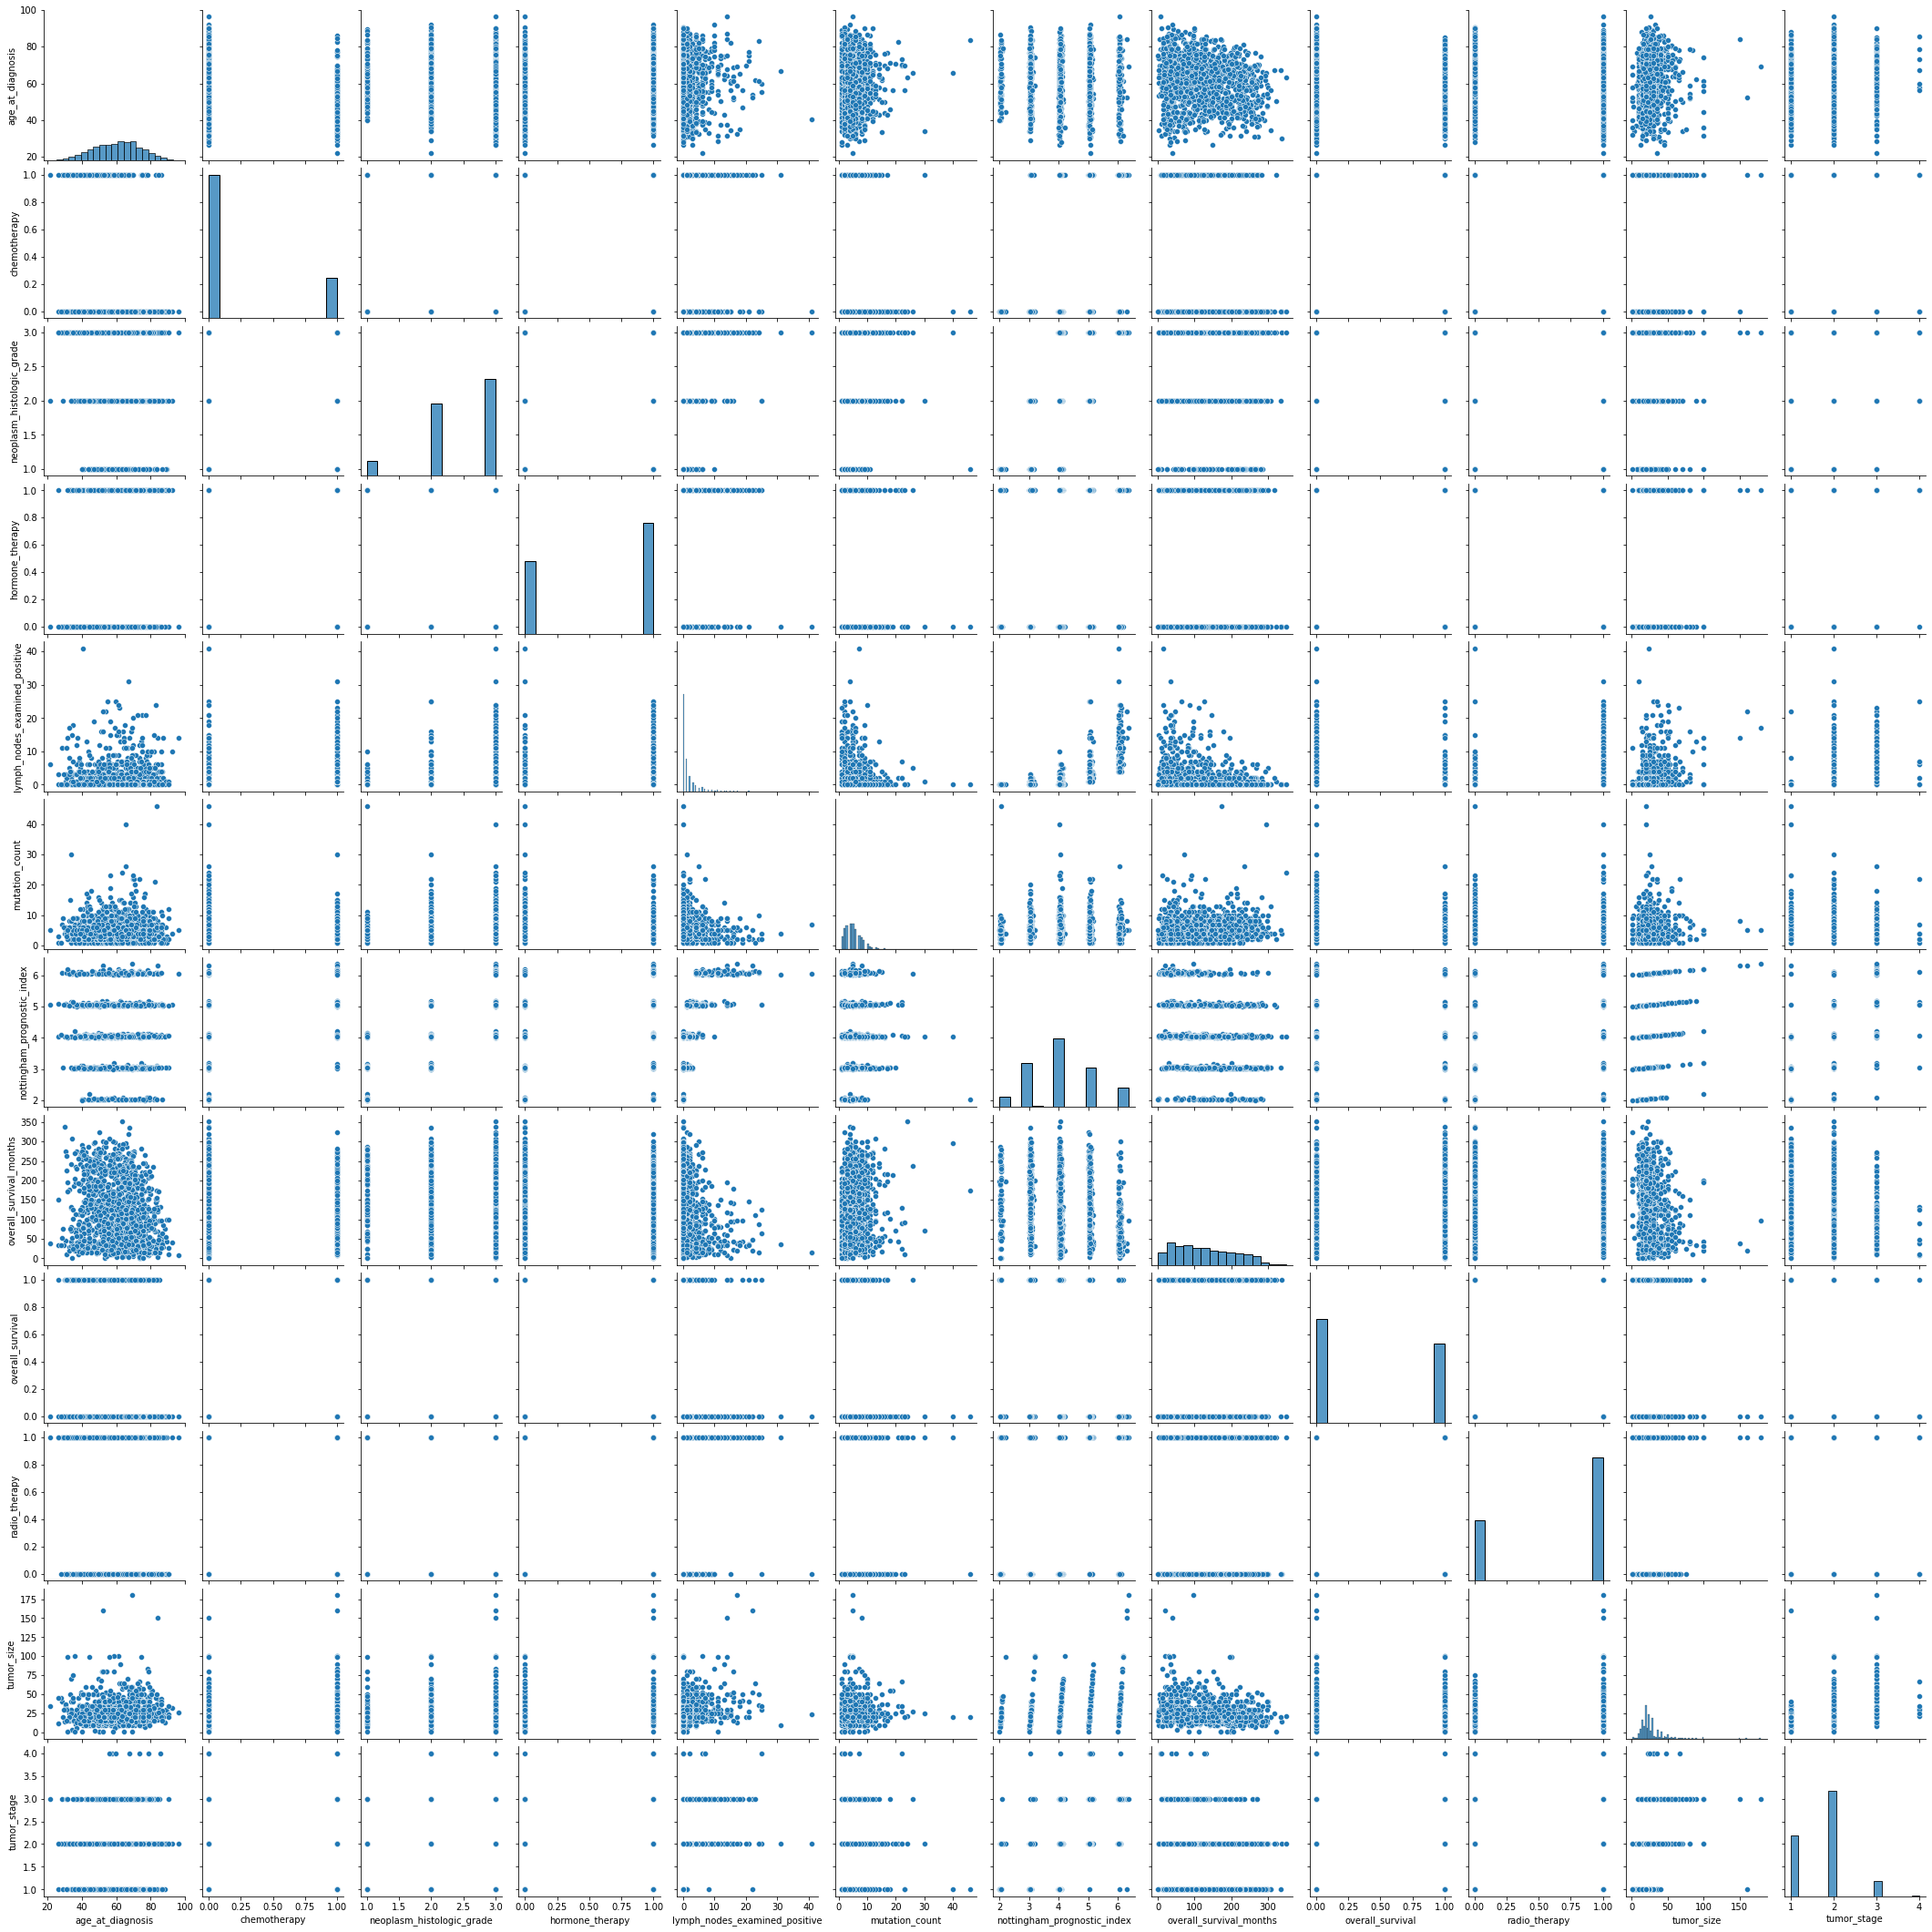

In [462]:
bc_subset = bc.iloc[:,0:27]
sns.pairplot(bc_subset)

<AxesSubplot:>

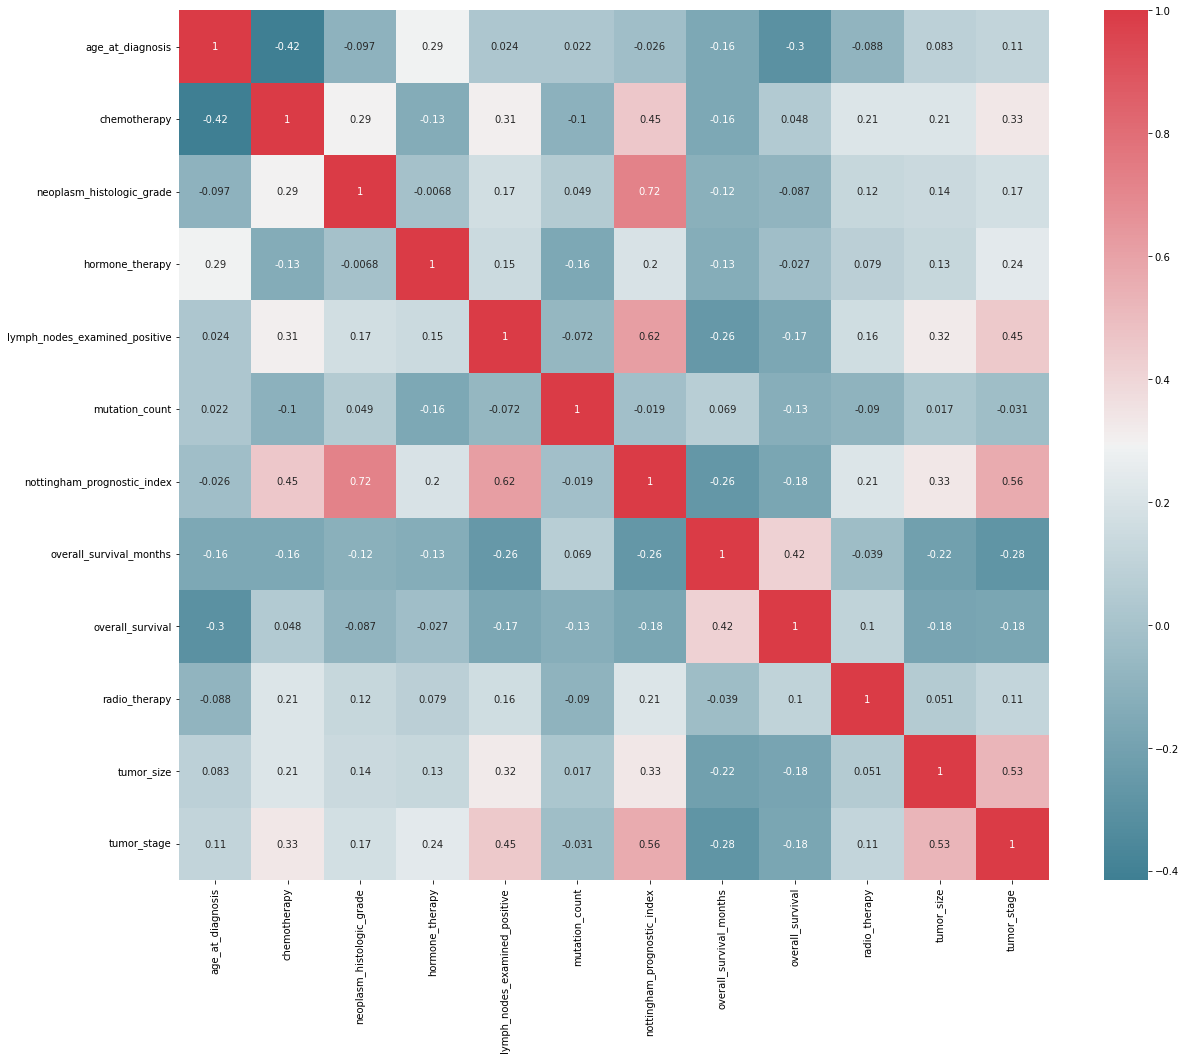

In [463]:
df_corr = bc_subset.corr()
f, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(df_corr, 
            mask=np.zeros_like(df_corr, dtype=bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, 
            ax=ax,annot=True
           )

In [464]:
bc['overall_survival'].value_counts()

0    705
1    535
Name: overall_survival, dtype: int64

In [465]:
bc['overall_survival'].value_counts(normalize=True)

0    0.568548
1    0.431452
Name: overall_survival, dtype: float64

<AxesSubplot:xlabel='overall_survival', ylabel='count'>

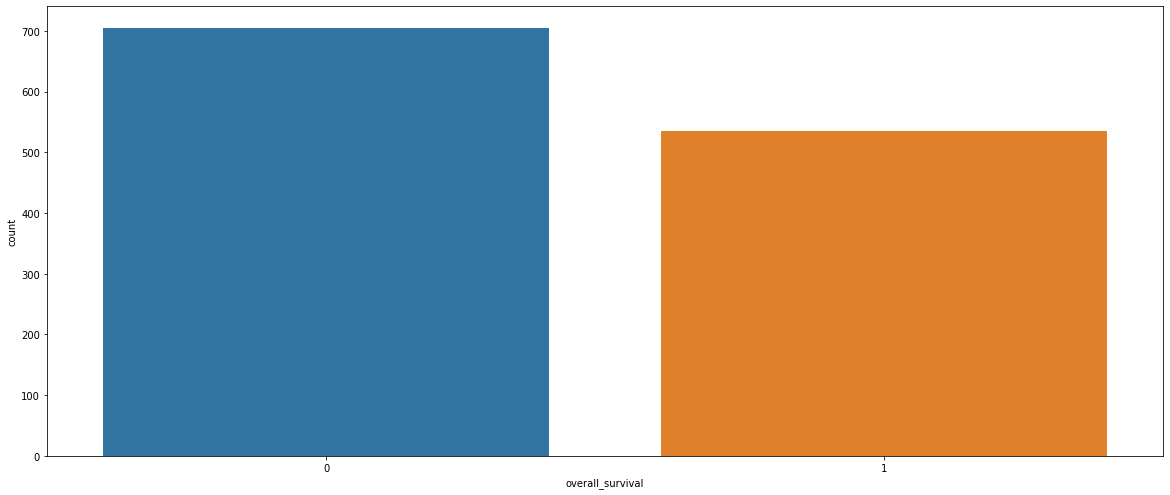

In [466]:
sns.countplot(x="overall_survival", data=bc) #histogram

<AxesSubplot:xlabel='type_of_breast_surgery', ylabel='overall_survival_months'>

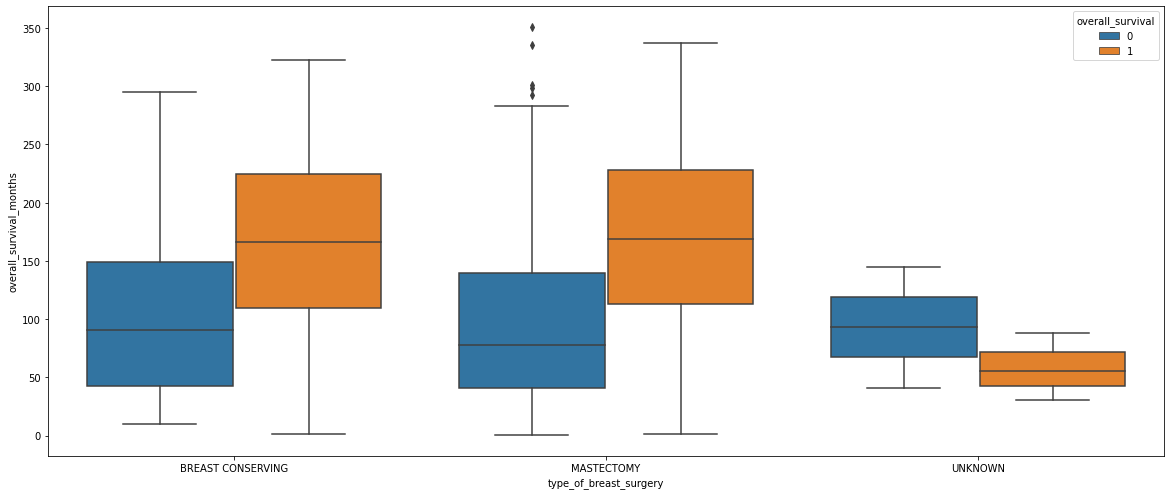

In [467]:
sns.boxplot(x=bc["type_of_breast_surgery"], y=bc["overall_survival_months"], hue=bc["overall_survival"])

<AxesSubplot:xlabel='cancer_type_detailed', ylabel='overall_survival_months'>

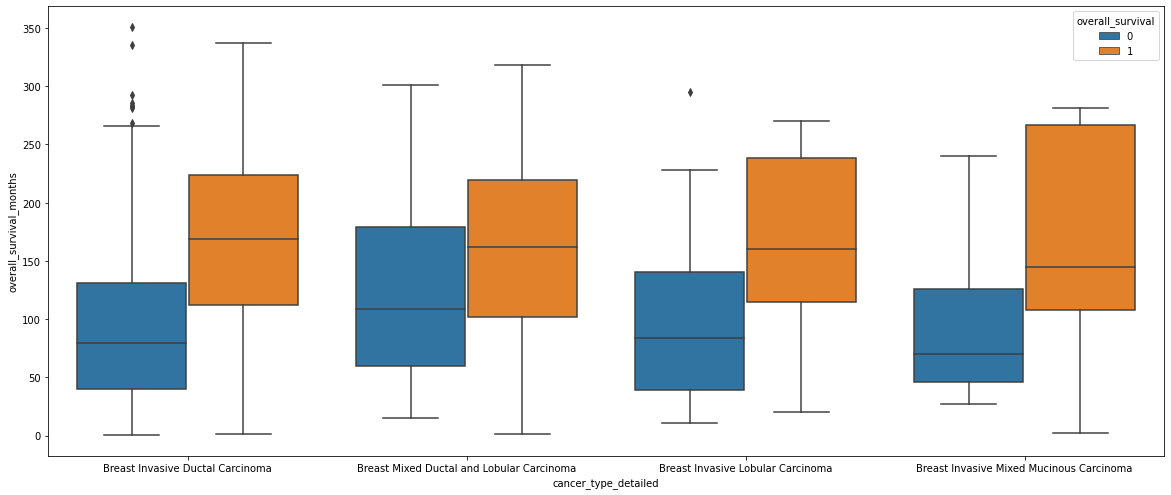

In [468]:
sns.boxplot(x=bc["cancer_type_detailed"], y=bc["overall_survival_months"], hue=bc["overall_survival"])

<AxesSubplot:xlabel='oncotree_code', ylabel='overall_survival_months'>

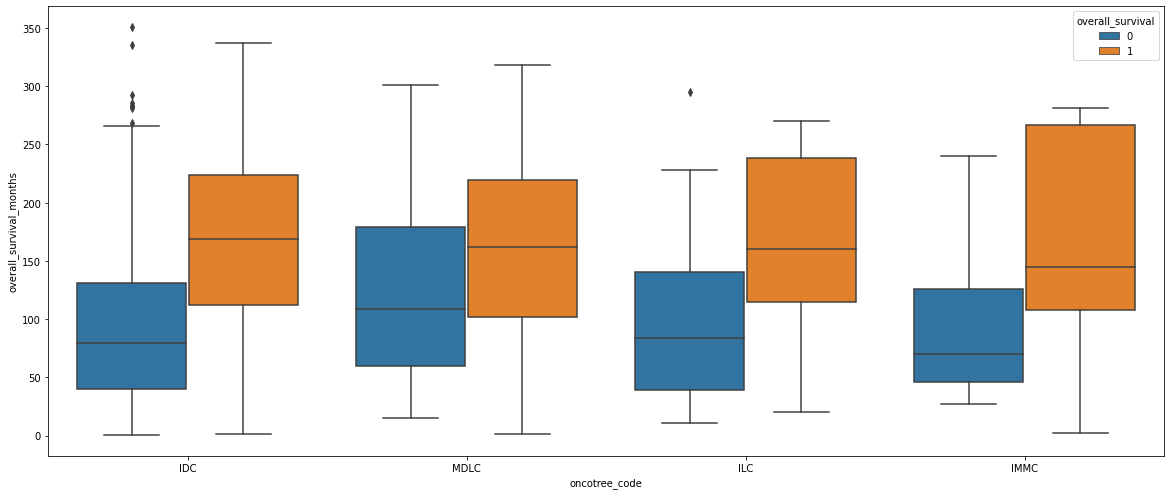

In [469]:
sns.boxplot(x=bc["oncotree_code"], y=bc["overall_survival_months"], hue=bc["overall_survival"])

In the scatterplots, it is difficult to see clear correlations, but a rapid drop in overall_survival_months is seen with increasing age at diagnosis, number of positive lymph nodes, tumor size and tumor stage. The heatplot shows to corresponding linear correlation coefficients, but the scatterplot suggest that the data is not entirely linearly correlated, but rather polynomial.

The data is not entirely balanced towards the target for classification. Thes needs to be taken into account when training classifiers, by either using class weights or perform SMOTE.

Several boxplots are drawn in function of the overall survival in months. This is done for the features: `type_of_breast_surgery`, `cancer_type_detailed` and `oncotree_code`. Neither of them show clear differences in months overall survival between the categories. Stratified for `overall_survival`, patients clearly survive longer when still a live (logically). There is one odd thing that can be seen on the boxplots for `type_of_breast_surgery`. The UNKNOWN category, that was created earlier, shows worse survival, as I already predicted. Furthermore, the living patients seems to be living shorter than the patients who died. This is not possible and indeed implies that these patient were not closely followed in hospital as they should be. As these values might mess up machine learning models, these values will be deleted at last.bc.cancer_type_detailed.replace('Breast', np.nan, inplace=True)
bc.tumor_stage.replace(0.1, 1, inplace=True)
bc.tumor_stage.replace(0.2, 2, inplace=True)
bc.tumor_stage.replace(0.3, 3, inplace=True)
bc.drop('patient_id', axis=1, inplace=True)
bc.drop('cohort', axis=1, inplace=True)
bc = bc.dropna() # Drop remaining NaN

In [470]:
bc = bc.replace('UNKNOWN', np.nan)
bc = bc.dropna() 
bc

age_at_diagnosis type_of_breast_surgery    cancer_type                       cancer_type_detailed cellularity  chemotherapy pam50_+_claudin-low_subtype er_status  neoplasm_histologic_grade her2_status_measured_by_snp6 her2_status tumor_other_histologic_subtype  hormone_therapy inferred_menopausal_state integrative_cluster primary_tumor_laterality  lymph_nodes_examined_positive  mutation_count  nottingham_prognostic_index oncotree_code  overall_survival_months  overall_survival pr_status  radio_therapy  tumor_size  tumor_stage     death_from_cancer   brca1   brca2   palb2    pten    tp53     atm    cdh1   chek2     nbn     nf1   stk11   bard1    mlh1    msh2    msh6    pms2   epcam  rad51c  rad51d   rad50     rb1    rbl1    rbl2   ccna1   ccnb1    cdk1   ccne1    cdk2  cdc25a   ccnd1    cdk4    cdk6   ccnd2  cdkn2a  cdkn2b     myc  cdkn1a  cdkn1b    e2f1    e2f2    e2f3    e2f4    e2f5    e2f6    e2f7    e2f8     src    jak1    jak2   stat1   stat2   stat3  stat5a  stat5b  \
1                43.19      BREAST CONSERVING  Breast Cancer           Breast Invasive Ductal Carcinoma        High             0                        LumA  Positive                        3.0                      NEUTRAL    Negative                     Ductal/NST                1                       Pre                4ER+                    Right                            0.0             2.0                        4.020           IDC                84.633333                 1  Positive              1        10.0          1.0                Living -1.3800  0.2777 -1.2154  0.5296 -0.0136 -0.2659  1.3594  0.7961  0.5419 -2.6059  0.5120  0.4390  1.2266  0.7612  0.1821  1.0104  0.5600 -0.4018 -0.2909  0.7440 -1.7488  0.4602  0.7835 -0.2690 -0.2715  0.3895 -0.6273  0.1813 -1.2643  1.1057  0.4108 -0.6040  0.0546  0.2754 -0.0952  0.7248  0.4389  1.8759 -1.8984 -0.3327 -1.4560  1.0011  0.0519 -0.3793 -0.4915 -1.3693 -0.3297  0.9804 -0.0104 -1.1940 -0.7991 -0.8428 -0.4983 -1.3251   
2                48.87             MASTECTOMY  Breast Cancer           Breast Invasive Ductal Carcinoma        High             1                        LumB  Positive                        2.0                      NEUTRAL    Negative                     Ductal/NST                1                       Pre                   3                    Right                            1.0             2.0                        4.030           IDC               163.700000                 0  Positive              0        15.0          2.0       Died of Disease  0.0670 -0.8426  0.2114 -0.3326  0.5141 -0.0803  1.1398  0.4187 -0.4030 -1.1305  0.2362 -0.1721 -1.7910  3.0955  0.6608  2.6127  2.5553 -0.0391 -0.4421  1.4528  1.4142  0.3143 -0.0662 -0.5558  0.6967  1.2949 -0.1245 -0.1109 -0.3923 -1.2747 -0.5312  0.2585  0.8958 -0.2270  1.1899 -0.7207  1.4829  3.0696  2.2248 -1.4859 -0.4127 -0.8333  0.2885 -0.3496 -0.3549  0.0908 -0.7181  1.5835  0.7379 -0.8346 -1.3487 -0.2243  0.0434 -1.0832   
3                47.68             MASTECTOMY  Breast Cancer  Breast Mixed Ductal and Lobular Carcinoma    Moderate             1                        LumB  Positive                        2.0                      NEUTRAL    Negative                          Mixed                1                       Pre                   9                    Right                            3.0             1.0                        4.050          MDLC               164.933333                 1  Positive              1        25.0          2.0                Living  0.6744 -0.5428 -1.6592  0.6369  1.6708 -0.8880  1.2491 -1.1889 -0.4174 -0.6165  1.0078 -0.4010 -1.3905  4.8798  0.0615  2.9414  4.1161 -0.3098 -1.3470  1.2102  1.5345 -0.6347  0.7279  0.0219  1.8801  0.0476 -0.6651 -1.4457 -0.3827 -0.4537 -1.5248  0.3689  1.1455  0.0432  1.0868 -0.5237  0.2119  3.4617  0.4610 -1.5404 -0.2119 -0.8333  1.8323  0.3869  1.3434  0.0409 -0.3804  0.6194  0.8552  0.3317 -0.5512 -1.2401 -0.8535 -0.0195   
4                76.97    

<AxesSubplot:xlabel='type_of_breast_surgery', ylabel='overall_survival_months'>

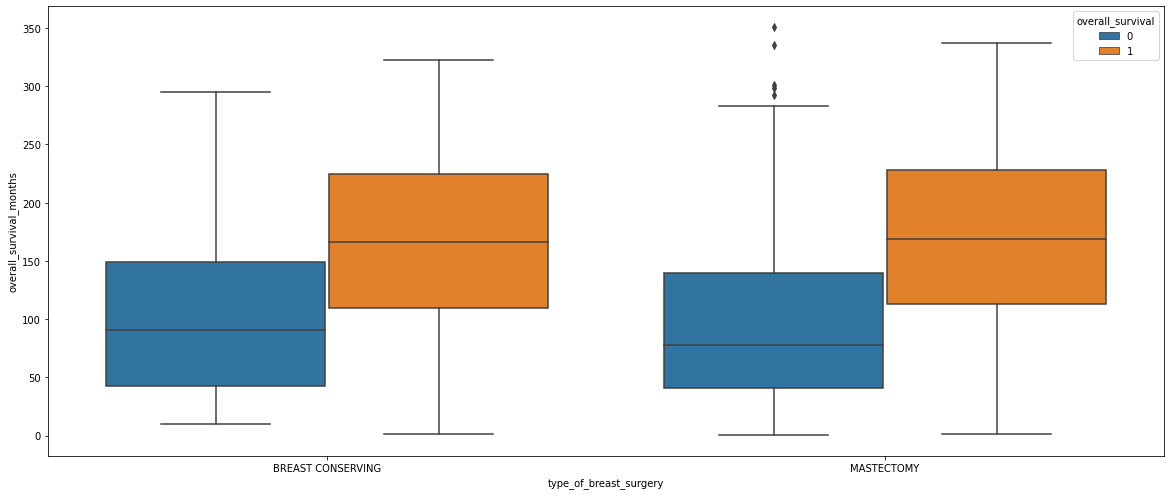

In [471]:
sns.boxplot(x=bc["type_of_breast_surgery"], y=bc["overall_survival_months"], hue=bc["overall_survival"])

### 3.4 Preprocessing
In the preprocessing, some features needs to be ordinal or one-hot encoded. This is followed by polynomial expansion to the second degree of all numerical values. Finaly the dataset is split up in features and targets (and training and test set). For the latter a test set of 20% will be used. Both sets for regression and classification will be made ready at the same time.

#### 3.4.1 Ordinal encoding 
Following feature still needs to be ordinal encoded: `cellularity` (mapping: ['Low', 'Moderate', High]). The other ordinal categories already are ordinal encoded.

In [472]:
bc = bc.replace('Low', 1)
bc = bc.replace('Moderate', 2)
bc = bc.replace('High', 3)
bc

age_at_diagnosis type_of_breast_surgery    cancer_type                       cancer_type_detailed  cellularity  chemotherapy pam50_+_claudin-low_subtype er_status  neoplasm_histologic_grade her2_status_measured_by_snp6 her2_status tumor_other_histologic_subtype  hormone_therapy inferred_menopausal_state integrative_cluster primary_tumor_laterality  lymph_nodes_examined_positive  mutation_count  nottingham_prognostic_index oncotree_code  overall_survival_months  overall_survival pr_status  radio_therapy  tumor_size  tumor_stage     death_from_cancer   brca1   brca2   palb2    pten    tp53     atm    cdh1   chek2     nbn     nf1   stk11   bard1    mlh1    msh2    msh6    pms2   epcam  rad51c  rad51d   rad50     rb1    rbl1    rbl2   ccna1   ccnb1    cdk1   ccne1    cdk2  cdc25a   ccnd1    cdk4    cdk6   ccnd2  cdkn2a  cdkn2b     myc  cdkn1a  cdkn1b    e2f1    e2f2    e2f3    e2f4    e2f5    e2f6    e2f7    e2f8     src    jak1    jak2   stat1   stat2   stat3  stat5a  stat5b  \
1                43.19      BREAST CONSERVING  Breast Cancer           Breast Invasive Ductal Carcinoma            3             0                        LumA  Positive                        3.0                      NEUTRAL    Negative                     Ductal/NST                1                       Pre                4ER+                    Right                            0.0             2.0                        4.020           IDC                84.633333                 1  Positive              1        10.0          1.0                Living -1.3800  0.2777 -1.2154  0.5296 -0.0136 -0.2659  1.3594  0.7961  0.5419 -2.6059  0.5120  0.4390  1.2266  0.7612  0.1821  1.0104  0.5600 -0.4018 -0.2909  0.7440 -1.7488  0.4602  0.7835 -0.2690 -0.2715  0.3895 -0.6273  0.1813 -1.2643  1.1057  0.4108 -0.6040  0.0546  0.2754 -0.0952  0.7248  0.4389  1.8759 -1.8984 -0.3327 -1.4560  1.0011  0.0519 -0.3793 -0.4915 -1.3693 -0.3297  0.9804 -0.0104 -1.1940 -0.7991 -0.8428 -0.4983 -1.3251   
2                48.87             MASTECTOMY  Breast Cancer           Breast Invasive Ductal Carcinoma            3             1                        LumB  Positive                        2.0                      NEUTRAL    Negative                     Ductal/NST                1                       Pre                   3                    Right                            1.0             2.0                        4.030           IDC               163.700000                 0  Positive              0        15.0          2.0       Died of Disease  0.0670 -0.8426  0.2114 -0.3326  0.5141 -0.0803  1.1398  0.4187 -0.4030 -1.1305  0.2362 -0.1721 -1.7910  3.0955  0.6608  2.6127  2.5553 -0.0391 -0.4421  1.4528  1.4142  0.3143 -0.0662 -0.5558  0.6967  1.2949 -0.1245 -0.1109 -0.3923 -1.2747 -0.5312  0.2585  0.8958 -0.2270  1.1899 -0.7207  1.4829  3.0696  2.2248 -1.4859 -0.4127 -0.8333  0.2885 -0.3496 -0.3549  0.0908 -0.7181  1.5835  0.7379 -0.8346 -1.3487 -0.2243  0.0434 -1.0832   
3                47.68             MASTECTOMY  Breast Cancer  Breast Mixed Ductal and Lobular Carcinoma            2             1                        LumB  Positive                        2.0                      NEUTRAL    Negative                          Mixed                1                       Pre                   9                    Right                            3.0             1.0                        4.050          MDLC               164.933333                 1  Positive              1        25.0          2.0                Living  0.6744 -0.5428 -1.6592  0.6369  1.6708 -0.8880  1.2491 -1.1889 -0.4174 -0.6165  1.0078 -0.4010 -1.3905  4.8798  0.0615  2.9414  4.1161 -0.3098 -1.3470  1.2102  1.5345 -0.6347  0.7279  0.0219  1.8801  0.0476 -0.6651 -1.4457 -0.3827 -0.4537 -1.5248  0.3689  1.1455  0.0432  1.0868 -0.5237  0.2119  3.4617  0.4610 -1.5404 -0.2119 -0.8333  1.8323  0.3869  1.3434  0.0409 -0.3804  0.6194  0.8552  0.3317 -0.5512 -1.2401 -0.8535 -0.0195   
4                76.97

#### 3.4.2 One-hot encoding
Following features need to be one-hot encoded: 'type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'pam50_+_claudin-low_subtype', 'her2_status_measured_by_snp6', 'tumor_other_histologic_subtype', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'oncotree_code', 'death_from_cancer' and all genomics columns.

Following features are binomial, but need to be replaced with 0/1 values: 'er_status', 'her2_status', 'pr_status'.

In [479]:
genomics = list(bc.iloc[:,bc.columns.get_loc("pik3ca_mut"):].columns)

In [481]:
oho_features = ['type_of_breast_surgery', 
            'cancer_type', 
            'cancer_type_detailed', 
            'pam50_+_claudin-low_subtype', 
            'her2_status_measured_by_snp6', 
            'tumor_other_histologic_subtype', 
            'inferred_menopausal_state', 
            'integrative_cluster', 
            'primary_tumor_laterality', 
            'oncotree_code',
            'death_from_cancer'] + genomics

In [482]:
bc = ohe_and_bind(bc, oho_features)

In [483]:
bc = bc.replace('Negative', 0)
bc = bc.replace('Positive', 1)

In [484]:
bc.head()

age_at_diagnosis  cellularity  chemotherapy  er_status  neoplasm_histologic_grade  her2_status  hormone_therapy  lymph_nodes_examined_positive  mutation_count  nottingham_prognostic_index  overall_survival_months  overall_survival  pr_status  radio_therapy  tumor_size  tumor_stage   brca1   brca2   palb2    pten    tp53     atm    cdh1   chek2     nbn     nf1   stk11   bard1    mlh1    msh2    msh6    pms2   epcam  rad51c  rad51d   rad50     rb1    rbl1    rbl2   ccna1   ccnb1    cdk1   ccne1    cdk2  cdc25a   ccnd1    cdk4    cdk6   ccnd2  cdkn2a  cdkn2b     myc  cdkn1a  cdkn1b    e2f1    e2f2    e2f3    e2f4    e2f5    e2f6    e2f7    e2f8     src    jak1    jak2   stat1   stat2   stat3  stat5a  stat5b    mdm2  tp53bp1  adam10  adam17   aph1a   aph1b  arrdc1    cir1   ctbp1   ctbp2    cul1    dll1    dll3    dll4    dtx1    dtx2    dtx3    dtx4   ep300   fbxw7   hdac1   hdac2    hes1    hes5    heyl    itch    jag1    jag2   kdm5a    lfng   maml1   maml2   maml3   ncor2   ncstn  \
1             43.19            3             0          1                        3.0            0                1                            0.0             2.0                        4.020                84.633333                 1          1              1        10.0          1.0 -1.3800  0.2777 -1.2154  0.5296 -0.0136 -0.2659  1.3594  0.7961  0.5419 -2.6059  0.5120  0.4390  1.2266  0.7612  0.1821  1.0104  0.5600 -0.4018 -0.2909  0.7440 -1.7488  0.4602  0.7835 -0.2690 -0.2715  0.3895 -0.6273  0.1813 -1.2643  1.1057  0.4108 -0.6040  0.0546  0.2754 -0.0952  0.7248  0.4389  1.8759 -1.8984 -0.3327 -1.4560  1.0011  0.0519 -0.3793 -0.4915 -1.3693 -0.3297  0.9804 -0.0104 -1.1940 -0.7991 -0.8428 -0.4983 -1.3251  0.8803  -1.5924 -1.2672 -0.2006  1.3135  0.6880  1.3366  1.5911  1.1926  0.3010 -0.4113 -1.5476 -0.1581 -0.1005 -0.9584 -0.1775 -0.7991 -0.3891 -0.4294  0.6385  1.6267 -0.9130  0.2582  0.0066 -0.5588  0.7234  0.2604 -0.6473  0.7122 -0.1773 -0.1606 -1.4582 -0.1651 -0.0066 -0.9120   
2             48.87            3             1          1                        2.0            0                1                            1.0             2.0                        4.030               163.700000                 0          1              0        15.0          2.0  0.0670 -0.8426  0.2114 -0.3326  0.5141 -0.0803  1.1398  0.4187 -0.4030 -1.1305  0.2362 -0.1721 -1.7910  3.0955  0.6608  2.6127  2.5553 -0.0391 -0.4421  1.4528  1.4142  0.3143 -0.0662 -0.5558  0.6967  1.2949 -0.1245 -0.1109 -0.3923 -1.2747 -0.5312  0.2585  0.8958 -0.2270  1.1899 -0.7207  1.4829  3.0696  2.2248 -1.4859 -0.4127 -0.8333  0.2885 -0.3496 -0.3549  0.0908 -0.7181  1.5835  0.7379 -0.8346 -1.3487 -0.2243  0.0434 -1.0832 -0.8822   0.7590  2.0364 -1.1229  3.1331 -0.4959 -1.0596  1.6744 -2.2695  0.2397  0.1616 -1.0439  0.9493 -1.7455 -0.8876  0.2312 -1.2906  1.1141 -1.5670 -1.6157 -1.8103  0.8620  1.1837 -0.1830 -0.4287  0.0269  0.9807 -1.2545 -1.6218 -1.2785 -1.9686  1.4406 -0.6574 -1.9701 -1.4975   
3             47.68            2             1          1                        2.0            0                1                            3.0             1.0                        4.050               164.933333                 1          1              1        25.0          2.0  0.6744 -0.5428 -1.6592  0.6369  1.6708 -0.8880  1.2491 -1.1889 -0.4174 -0.6165  1.0078 -0.4010 -1.3905  4.8798  0.0615  2.9414  4.1161 -0.3098 -1.3470  1.2102  1.5345 -0.6347  0.7279  0.0219  1.8801  0.0476 -0.6651 -1.4457 -0.3827 -0.4537 -1.5248  0.3689  1.1455  0.0432  1.0868 -0.5237  0.2119  3.4617  0.4610 -1.5404 -0.2119 -0.8333  1.8323  0.3869  1.3434  0.0409 -0.3804  0.6194  0.8552  0.3317 -0.5512 -1.2401 -0.8535 -0.0195  0.2551  -1.0064  1.4659 -1.0490  2.3645 -1.2458  1.4919  2.6438 -0.7268 -0.4622  0.1933  0.4481  1.6109 -0.5916 -0.4730 -0.2765 -1.1845  1.1098 -1.7947 -1.3703 -0.3412  1.0671 -0.1616 -0.5077 -1.8552  0.4120 -1.4933 -0.8333 -2.2726  1.1498 -1.5455 -0.2630 -0.8255 -0.9941 -2.5452   

#### 3.4.3 Polynomial expansion
As previously seen in the scatterplots, some numerical values are rather polynomial correlated with `overall_survival_months`. For this, third degree features will be created. Higher degrees is not recommended as there are already 5852 columns at this point. Also, only numerical values of the first 27 columns will be expanded, leaving all transcriptomics data untouched.

In [485]:
## x.3.2: Polynomiale expansie
poly_feat = ['age_at_diagnosis', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'tumor_size']
pol = bc[poly_feat]
nopol = bc.drop(poly_feat, axis=1)
nopol.reset_index(drop=True, inplace=True)

graad = 3 

poly = PolynomialFeatures(graad)
poly.fit(pol)
polynom = pd.DataFrame(poly.transform(pol), columns=poly.get_feature_names_out(pol.columns))

In [486]:
bc_preprocessed = pd.concat([polynom, nopol], axis=1)

In [487]:
bc_preprocessed.shape

(1235, 5902)

In [488]:
bc_preprocessed.head()

1  age_at_diagnosis  lymph_nodes_examined_positive  mutation_count  nottingham_prognostic_index  tumor_size  age_at_diagnosis^2  age_at_diagnosis lymph_nodes_examined_positive  age_at_diagnosis mutation_count  age_at_diagnosis nottingham_prognostic_index  age_at_diagnosis tumor_size  lymph_nodes_examined_positive^2  lymph_nodes_examined_positive mutation_count  lymph_nodes_examined_positive nottingham_prognostic_index  lymph_nodes_examined_positive tumor_size  mutation_count^2  mutation_count nottingham_prognostic_index  mutation_count tumor_size  nottingham_prognostic_index^2  nottingham_prognostic_index tumor_size  tumor_size^2  age_at_diagnosis^3  age_at_diagnosis^2 lymph_nodes_examined_positive  age_at_diagnosis^2 mutation_count  age_at_diagnosis^2 nottingham_prognostic_index  age_at_diagnosis^2 tumor_size  age_at_diagnosis lymph_nodes_examined_positive^2  age_at_diagnosis lymph_nodes_examined_positive mutation_count  \
0  1.0             43.19                            0.0             2.0                        4.020        10.0           1865.3761                                            0.00                            86.38                                     173.62380                       431.90                              0.0                                           0.0                                               0.00                                               0.0               4.0                                       8.040                       20.0                      16.160400                                  40.200         100.0        80565.593759                                            0.0000                          3730.7522                                     7498.811922                     18653.7610                                              0.00                                               0.00               
1  1.0             48.87                            1.0             2.0                        4.030        15.0           2388.2769                                           48.87                            97.74                                     196.94610                       733.05                              1.0                                           2.0                                               4.03                                              15.0               4.0                                       8.060                       30.0                      16.240900                                  60.450         225.0       116715.092103                                         2388.2769                          4776.5538                                     9624.755907                     35824.1535                                             48.87                                              97.74               
2  1.0             47.68                            3.0             1.0                        4.050        25.0           2273.3824                                          143.04                            47.68                                     193.10400                      1192.00                              9.0                                           3.0                                              12.15                                              75.0               1.0                                       4.050                       25.0                      16.402500                                 101.250         625.0       108394.872832                                         6820.1472                          2273.3824                                     9207.198720                     56834.5600                                            429.12                                             143.04               
3  1.0             76.97                            8.0             2.0                        6.080        40.0           5924.3809                                          615.76                           153.94                    

### 3.5 Splitting the dataset
The dataset will now be splitted into features and targets. This will be done immediately for regression and classification. The target for regression is `overall_survival_months` and for classification `overall_survival`.

Furthermore, the dataset will also be split into a training and a test set. The size of the test set will be set to 20%.

In [489]:
y_clf = bc_preprocessed['overall_survival'].values.astype('int')
y_reg = bc_preprocessed['overall_survival_months'].values.astype('int')
X = pd.DataFrame(bc_preprocessed.drop(['overall_survival', 'overall_survival_months'], axis=1))

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.20, random_state=0)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.20, random_state=0)

### 3.6 Scaling
The data in this dataset has a few outliers and a rather small variance. Normalization can therefore be used. Standardization is also an option, given the rather gaussian distribution of most of the data. As it is known that normalization is more useful for regression and standardization is more useful for classification in order to improve the learning rate. Both scalings will be used on their respective datasets.

In [490]:
ss_clf = preprocessing.MinMaxScaler()
ss_clf.fit(X_train_clf)
X_train_clf = ss_clf.transform(X_train_clf)
X_test_clf = ss_clf.transform(X_test_clf)

ss_reg = preprocessing.MinMaxScaler()
ss_reg.fit(X_train_reg)
X_train_reg = ss_reg.transform(X_train_reg)
X_test_reg = ss_reg.transform(X_test_reg)
print('Data transformed: StandardScaler for classification and regression')

Data transformed: StandardScaler for classification and regression


### 3.7 Conclusion PART3
This dataset contained a lot of missing values, some inconsistent values and 2 non-contributive columns. When possible these were recalculated, otherwise these patients or features were omtitted. In the end only 1235 patients and 689 columns remained.

Statistical pre-analysis shows that with regards to linear correlatieon following numerical features were well correlated with overall survival in months and overall survival status, the two columns chosen to be used as target for regression and classification.
- age_at_diagnosis: negatively correlated
- lymph_nodes_examined_positive: negatively correlated
- tumor_size: negatively correlated
- tumor_stage: negatively correlated

This data shows an unbalance in the data towards the target for classification. This needs to be taken into account while training the classification models.

Boxplots for the categorical data `type_of_breast_surgery`, `cancer_type_detailed` and `oncotree_code`, do not show clear differences in `overall_survival_months` between the categories, but they do show a difference between the patients that live and patients that died.

The dataset is further processed with ordinal encoding, one-hot encoding and polynomial expansion. The final dataset contains 5902 columns and 1235 patients. After splitting the dataset in target, features; train and test set, the numerical features are scaled.

The data is now ready for training machine learning models.


## PART 4: Regression
### 4.1 Linear regression and regularization
Linear regression with or without regularization (L1 and L2) is crossvalidated with GridSearch against the training set for regression.

In [492]:
# Initiate models
lregmodel = linear_model.LinearRegression()
ridgemodel = linear_model.Ridge(tol=0.0001,fit_intercept=True, max_iter=10000) # L2 regularisatie
lassomodel = linear_model.Lasso(tol=0.0001,fit_intercept=True, max_iter=10000) # L1 regularisatie
elasticmodel = linear_model.ElasticNet(tol=0.0001,fit_intercept=True, max_iter=10000)

# Initiate grids
param1 = {}
param1['regression'] = [lregmodel]

param2 = {}
param2['regression__alpha'] = np.logspace(-2,3,10)
param2['regression'] = [ridgemodel]

param3 = {}
param3['regression__alpha'] = np.logspace(-2,3,10)
param3['regression'] = [lassomodel]

param4 = {}
param4['regression__alpha'] = np.logspace(-2,3,10)
param4['regression'] = [elasticmodel]

reg_params = [param1, param2, param3, param4]

# Initiate pipeline
reg_pipeline = Pipeline([('regression', lregmodel)])

# Initiate gridsearch
reg_gs = GridSearchCV(reg_pipeline, reg_params, cv=8, n_jobs=-1, scoring='r2', verbose=1)

# Fit grid search
reg_gs.fit(X_train_reg, y_train_reg)

# Best parameters and score
print(f"Best parameters:\t{reg_gs.best_params_}")
print(f"Best score: \t{reg_gs.best_score_}")

Fitting 8 folds for each of 31 candidates, totalling 248 fits
Best parameters:	{'regression': ElasticNet(alpha=0.1291549665014884, max_iter=10000), 'regression__alpha': 0.1291549665014884}
Best score: 	0.3393733139535753


In [497]:
y_pred_reg = reg_gs.predict(X_test_reg)
r2train = reg_gs.score(X_train_reg, y_train_reg)
r2test = reg_gs.score(X_test_reg, y_test_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)

print(f"For the best model, the R² for training set is: \t{r2train}")
print(f"For the best model, the R² for test set is: \t{r2test}")
print(f"For the best model, the MAE for training set is: \t{mae}")
print(f"For the best model, the MSE for training set is: \t{mse}")

For the best model, the R² for training set is: 	0.4982364004878629
For the best model, the R² for test set is: 	0.384038312261218
For the best model, the MAE for training set is: 	52.38304741019719
For the best model, the MSE for training set is: 	3905.8724177640747


Based on a grid search for hyperparameter and model tuning and 8-fold crossvalidation. The best linear regression model would be one with ElasticNet regularization (combined L1 and L2 regularization). This means some features will be excluded from the model, while others will receive higher error costs. 

The &alpha; value is smaller than 1. Smaller &alpha; values means that your model might risk overfitting. Looking at the different R² values, there is indeed slightly overfitting of the training set, as the performance on the test set is lower (R² is more than 0.10 points lower). Moreover, the MAE and MSE are not optimal either. The MAE means that for every prediction the mean error that can be encountered is 52 months. Although the standard deviation in the target is 76.334148, this is a very big error margin in terms of survival (more than 4 years error margin). 

### 4.2 LightGBM regression
LightGBM regression is a regression model, that is based on tree-decisions. As transcriptomics and genomics depends on each other and might lead to better or worse histological grades, tree-decision based regression, might be a suitful model.

In [507]:
lgbmodel = lgb.LGBMRegressor()
lgbmodel.fit(X_train_reg, y_train_reg, eval_set=[(X_test_reg, y_test_reg),(X_train_reg, y_train_reg)],eval_metric='r2')
y_pred_lgbm = lgbmodel.predict(X_test_reg)
print("LGBM R2_SCORE:", r2_score(y_test_reg, y_pred_lgbm))

[1]	training's l2: 5430.88	valid_0's l2: 5952.03
[2]	training's l2: 4846.28	valid_0's l2: 5589.68
[3]	training's l2: 4338.28	valid_0's l2: 5268.92
[4]	training's l2: 3914.5	valid_0's l2: 5007.66
[5]	training's l2: 3525.93	valid_0's l2: 4809.07
[6]	training's l2: 3207.48	valid_0's l2: 4644.38
[7]	training's l2: 2936.88	valid_0's l2: 4528.01
[8]	training's l2: 2672.3	valid_0's l2: 4417.78
[9]	training's l2: 2455.01	valid_0's l2: 4336.67
[10]	training's l2: 2267.79	valid_0's l2: 4268.91
[11]	training's l2: 2092.26	valid_0's l2: 4161.59
[12]	training's l2: 1928.91	valid_0's l2: 4121.34
[13]	training's l2: 1785.3	valid_0's l2: 4116.72
[14]	training's l2: 1649.57	valid_0's l2: 4128.64
[15]	training's l2: 1535.94	valid_0's l2: 4102.57
[16]	training's l2: 1429.72	valid_0's l2: 4069.41
[17]	training's l2: 1327.18	valid_0's l2: 4044.68
[18]	training's l2: 1231.92	valid_0's l2: 4009.09
[19]	training's l2: 1145.18	valid_0's l2: 3985.47
[20]	training's l2: 1071.1	valid_0's l2: 3963.02
[21]	training

In [493]:
X_train_reg

array([[0.        , 0.59077461, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.15909091, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.45548682, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.25793437, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.46382464, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.5006724 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Stap 4: Classificatie
Gebruik Logistische regressie, SVM om een categorieke variabele target te voorspellen.

Stappenplan (zelfde als bij lineaire regressie, maar meerdere type modellen te testen bij Grid search):
1. Initieel model zonder tweaking
2. Initieel model beoordelen (Precisie, Recall, Accuracy, Confusiematrix, ROC en AUC)
3. Model tunen
    1. Nieuwe features creëren
    2. Polynomiale expansie
    3. Regularisatie
    4. Hyperparameter tuning: Grid search/Random search
4. Model selecteren op basis van Grid search
5. Finaal model evalueren

Het is moeilijk om hier voorbeeldcode te geven. Dit moet bijna altijd worden aangepast aan de situatie. Bij Classificatie is het altijd leuk om de ROC curves te tekenen.

## Stap 5: Clustering
Gebruik een clustering methode om een cluster te voorspellen.

Stappenplan (zelfde als bij lineaire regressie, maar meerdere type modellen te testen bij Grid search):
1. Initieel model zonder tweaking
2. Initieel model beoordelen (nog op te zoeken: evaluatieparameters)
3. Model tunen
    1. Nieuwe features creëren
    2. Polynomiale expansie
    3. Regularisatie
    4. Hyperparameter tuning: Grid search/Random search (? geen idee of dit past)
4. Model selecteren op basis van Grid search
5. Finaal model evalueren

Het is moeilijk om hier voorbeeldcode te geven. Dit moet bijna altijd worden aangepast aan de situatie. We moeten blijkbaar niet alle attributen gebruiken in het model. We mogen ons beperken tot de attributen met een goede performance of een combinatie van verschillende goede attributen. We moeten het wel proberen te baseren op dezelfde attributen als bij classificatie.

In [ ]:
# Stap x.2: Model beoordelen
## Linear, Ridge en Lasso
r2train = lregmodel.score(X_train, y_train)
r2test = lregmodel.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

## Logistic en SVM
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)*100
matrix = confusion_matrix(y_test, y_pred)

## Clustering
# Wordt nog aangevuld

In [ ]:
lregmodel = linear_model.LinearRegression()
ridgemodel = linear_model.Ridge(alpha=alpha,tol=0.0001,fit_intercept=True) # L2 regularisatie
lasso = linear_model.Lasso(alpha=alpha,tol=0.0001,fit_intercept=True) # L1 regularisatie
logrmodel = linear_model.LogisticRegression(C=1, solver='liblinear', class_weight='balanced', multi_class='ovr')
svmmodel = svm.SVC(kernel='linear',C=0.01)

In [ ]:
# Stap x.3: Model tunen (werk opnieuw vanaf de basisset)
## x.3.1: Nieuwe features creëren
df.insert(df.columns.size-1, 'new_feature', df.feature1*df.feature2) # kan ook som, min, deling


## x.3.2: Polynomiale expansie
pol = df[['lijst met features met continue variabelen']]
nopol = lego.drop(['lijst met features met continue variabelen'], axis=1)

graad = 4 

poly = PolynomialFeatures(graad)
poly.fit(pol)
polynom = pd.DataFrame(poly.transform(pol), columns=poly.get_feature_names_out(pol.columns))

### Belangrijk! vul aan met One-hot encoding en ordinal encoding indien nodig, daarna opnieuw opsplitsen
ord_features = ['feature1', 'feature2'] # lijst met alle colomnamen met ordinale features
rest_features = listdiff(df.columns, ord_features)
nopol = pd.DataFrame(ordinal_trf.fit_transform(nopol), columns=[ord_features, rest_features])

ohe_features = [featureA, featureB]
nopol = ohe_and_bind(nopol, ohe_features)

df_preprocessed = pd.concat([polynom, nopol], axis=1)

y = df_preprocessed['target'].values.astype('int')
X = pd.DataFrame(df_preprocessed.drop('target', axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=0)


## X.3.3: Regularisatie (kan ook tijdens gridsearch)
### Linear regression --> gebruik Lasso of Ridge regressie
### Logistic regression --> standaard is L2
lr = linear_model.LogisticRegression(C=1, solver='liblinear', class_weight='balanced', penalty='l1')
### SVM heeft geen regularisatie maar wel kernels
svmmodel = svm.SVC(kernel='poly',C=10000000)


## X.3.4: Hyperparameter tuning met grid search of random search
### linear regression alleen bij ridge/lasso en weinig zin
lrparam = {'alpha' = np.logspace(-5, 4, 10)}

grid_search = GridSearchCV(estimator = model, 
                           param_grid = lrparam,
                           scoring = 'r2', # roc_auc, f1_weighted, f1_macro, recall, ...
                           cv = 15,
                           n_jobs = -1,
                           verbose = 5)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  
y_pred = grid_search.predict(X_test)
r2train = lregmodel.score(X_train, y_train)
r2test = lregmodel.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


### logistic regression grid search
logrparam = {
    'solver' = ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty' = ['none', 'l1', 'l2', 'elasticnet'],
    'C' = np.logspace(-5, 4, 10)
}

grid_search = GridSearchCV(estimator = model, 
                           param_grid = logrparam,
                           scoring = 'accuracy', # roc_auc, f1_weighted, f1_macro, recall, ...
                           cv = 15,
                           n_jobs = -1,
                           verbose = 5)

grid_search = grid_search.fit(X_train, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  
y_pred = grid_search.predict(X_test)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)*100
matrix = confusion_matrix(y_test, y_pred)

### logistic regression random search
logrparam = {
    'solver' = ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty' = ['none', 'l1', 'l2', 'elasticnet'],
    'C' = loguniform(1e-5, 100)
}

random_search = RandomizedSearchCV(model, 
                                   logrparam, 
                                   n_iter=20, 
                                   scoring='accuracy', 
                                   n_jobs=-1, 
                                   cv=5, 
                                   random_state=1)

random_search = random_search.fit(X_train, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  
y_pred = random_search.predict(X_test)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)*100
matrix = confusion_matrix(y_test, y_pred)

### SVM grid search
svmparamaters = [ 
        {'kernel': ['linear'], 'C': np.linspace(0.01,20,10)},
        {'kernel': ['rbf'], 'C': np.linspace(0.01,20,10), 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2]},
        {'kernel': ['poly'], 'C':np.linspace(0.01,20,10)} ]

grid_search = GridSearchCV(estimator = model, 
                           param_grid = svmparamaters,
                           scoring = 'accuracy', # roc_auc, f1_weighted, f1_macro, recall, ...
                           cv = 15,
                           n_jobs = -1,
                           verbose = 5)

grid_search = grid_search.fit(X_train, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  
y_pred = grid_search.predict(X_test)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)*100
matrix = confusion_matrix(y_test, y_pred)

### SVM random search
model = SVC(probability=True)
parameters = {'kernel': ['linear','rbf','poly'],
              'C': uniform(0.01, 20), # haal C uit een random uniform distribution
              'gamma': uniform(0.001, 0.2)}


n_iter_search = 20

random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  
y_pred = random_search.predict(X_test)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)*100
matrix = confusion_matrix(y_test, y_pred)

#### Nog aan te vullen voor clustering

## Conclusion
This dataset can be used for machine learning for linear regression, classification and for clustering. Nevertheless, this dataset needed severe preprocessing, as the data was not cleanly presented. Missing and inconsistent values needed to be calculated or removed. This made the dataset shrink to 1240 patients and 689 columns. For several features ordinal or one-hot encoding still needed to be performed. After preprocessing, this dataset contained X columns.



Conclusie schrijven over:
- Dataset
    - Goed/slecht en waarom?
    - Problemen in de dataset
- Model
    - Beste model voor elke techniek
    - Performance
    - Overfitting/underfitting
    - Kan gebruikt worden in dagdagelijkse praktijk?

## References
1. Curtis, C., Shah, S.P., Chin, S.-F., Turashvili, G., Rueda, O.M., Dunning, M.J., Speed, D., Lynch, A.G., Samarajiwa, S., Yuan, Y., Gräf, S., Ha, G., Haffari, G., Bashashati, A., Russell, R., Mckinney, S., Langerød, A., Green, A., Provenzano, E., Wishart, G., Pinder, S., Watson, P., Markowetz, F., Murphy, L., Ellis, I., Purushotham, A., Børresen-Dale, A.-L., Brenton, J.D., Tavaré, S., Caldas, C., Aparicio, S., 2012. The genomic and transcriptomic architecture of 2,000 breast tumours reveals novel subgroups. Nature 486, 346–352.. doi:10.1038/nature10983